In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

from datetime import datetime;now = datetime.now;t00=now();

import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

In [ ]:
#data = np.random.rand(131,160,64,64)
#data = np.load('/content/drive/My Drive/abide_data_60.npy')
data = np.load('/content/drive/My Drive/abide_data_60iso_1060.npy')

for s in range(data.shape[0]):
  data[s,:,:,:] = (data[s,:,:,:]-data[s,:,:,:].min()) / (data[s,:,:,:].max()-data[s,:,:,:].min())
  
print(data.shape)

(1060, 1, 64, 64, 64)


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla P4


In [ ]:
# Autoencoder class
class CAE(nn.Module):
    def __init__(self,input_shape,k=1):
        super().__init__()
        
        # Stuff
        self.input_shape = input_shape
        self.batch_size = input_shape[0]

        self.lrelu = torch.nn.LeakyReLU(negative_slope=.02)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

        # Shapes and sizes
        #R = np.ones(shape=self.input_shape)
        #R = torch.tensor(R).float()

        bias_bool = False # Do you want padding or not 

        # Encoder
        self.enc_C1 = nn.Conv3d(in_channels=1,out_channels=int(4*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C2 = nn.Conv3d(in_channels=int(4*k),out_channels=int(8*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C3 = nn.Conv3d(in_channels=int(8*k),out_channels=int(16*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C4 = nn.Conv3d(in_channels=int(16*k),out_channels=int(32*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C5 = nn.Conv3d(in_channels=int(32*k),out_channels=int(64*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)

        self.batchNormE1 = nn.BatchNorm3d(int(4*k), affine=False)
        self.batchNormE2 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormE3 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormE4 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormE5 = nn.BatchNorm3d(int(64*k), affine=False)

        self.batchNormD1 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormD2 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormD3 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormD4 = nn.BatchNorm3d(int(4*k), affine=False)
        #self.batchNormD5 = nn.BatchNorm3d(int(4*k), affine=False)

        self.dec_C1 = nn.ConvTranspose3d(in_channels=int(64*k),out_channels=int(32*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C2 = nn.ConvTranspose3d(in_channels=int(32*k),out_channels=int(16*k),kernel_size=4, stride=2, padding=1,bias=bias_bool) 
        self.dec_C3 = nn.ConvTranspose3d(in_channels=int(16*k),out_channels=int(8*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C4 = nn.ConvTranspose3d(in_channels=int(8*k),out_channels=int(4*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C5 = nn.ConvTranspose3d(in_channels=int(4*k),out_channels=1,kernel_size=4, stride=2, padding=1,bias=bias_bool)

    def forward(self,hello):
      
        activation = self.relu( self.enc_C1(hello) )
        activation = self.batchNormE1(activation)

        activation = self.relu( self.enc_C2(activation) )
        activation = self.batchNormE2(activation)

        activation = self.relu( self.enc_C3(activation) )
        activation = self.batchNormE3(activation)

        activation = self.relu( self.enc_C4(activation) )
        activation = self.batchNormE4(activation)

        activation = self.relu( self.enc_C5(activation) )
        activation = self.batchNormE5(activation)

        activation = self.relu( self.dec_C1(activation))
        activation = self.batchNormD1(activation)

        activation = self.relu( self.dec_C2(activation) )
        activation = self.batchNormD2(activation)

        activation = self.relu( self.dec_C3(activation) )
        activation = self.batchNormD3(activation)

        activation = self.relu( self.dec_C4(activation) )
        activation = self.batchNormD4(activation)

        activation = self.relu( self.dec_C5(activation) )
        #activation = self.batchNormD5(activation)

        return activation


In [ ]:
## Convert data 
D = torch.tensor(data[:,:,:,:,:]).float()
#D = torch.tensor(np.random.rand(1060, 1, 64, 64, 64)*.001).float()
#D = (D-D.min()) / (D.max()-D.min())
data_batch = D[0:5,:,:,:,:]

## Model Definition
model = CAE(data_batch.shape,k=10) # Initiate mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #  use gpu if available
model.to(device)

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model.apply(weights_init_uniform_rule)

#model.to(device)

#optimizer = optim.Adam(model.parameters(), lr=1e-3,)
optimizer = optim.Adam(model.parameters(), lr=.01,weight_decay=.01)
#optimizer = optim.SGD(model.parameters(),lr=.001,weight_decay=.0,momentum=.0)
#optimizer = optim.RMSprop(model.parameters(),lr=.1)
#criterion = nn.MSELoss()
print(device)

## Training Parameters
num_epochs = 501
batch_size = 5
ndata = data.shape[0]
n_batches = np.floor(D.shape[0]/5)
batches = np.array([np.arange((i)*5,(i+1)*5) for i in range(int(n_batches))])
D = D.cuda()
track = list();

ofdir = os.path.join(os.path.curdir,'drive','My Drive','BC-MRI-AE','models')
print(ofdir)

session_name = '5layer-128-batchNorm'
#session_name = 'CAE_Nolinear_SGD1e3_'

cuda
./drive/My Drive/BC-MRI-AE/models


In [ ]:
def myLoss(outputs,data_batch):
  return torch.sum(torch.square(outputs.view(-1)-data_batch.view(-1)))

In [ ]:
#model = CAE(data_batch.shape,k=.5)
latentSpaceSize = model.enc_C5(model.enc_C4(model.enc_C3(model.enc_C2(model.enc_C1(data_batch))))).shape

latentSpaceDim = np.prod(latentSpaceSize)

print(f'latent space size {latentSpaceSize}')
print(f'latent space ndim {latentSpaceDim/latentSpaceSize[0]}')

SyntaxError: ignored

epoch 0/501 | batch 0/212.0 | time 0:00:00.208206 | loss 54458.27344
epoch 0/501 | batch 50/212.0 | time 0:00:01.852060 | loss 16038.35156
epoch 0/501 | batch 100/212.0 | time 0:00:03.445201 | loss 13483.73535
epoch 0/501 | batch 150/212.0 | time 0:00:05.039293 | loss 10242.35156
epoch 0/501 | batch 200/212.0 | time 0:00:06.632490 | loss 12401.26562
saved
./drive/My Drive/BC-MRI-AE/models/5layer-128-batchNorme0_2020-10-30 18:05:44.127459
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0', grad_fn=<ViewBackward>)


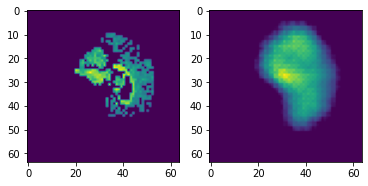

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


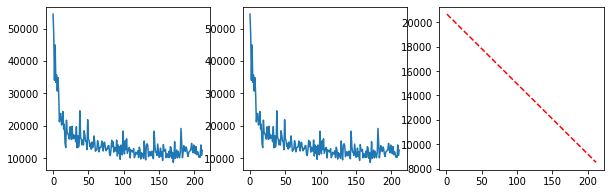

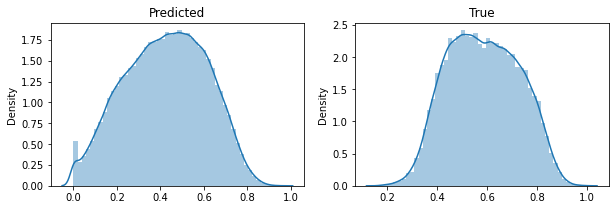

epoch 1/501 | batch 0/212.0 | time 0:00:12.213314 | loss 11857.35352
epoch 1/501 | batch 50/212.0 | time 0:00:13.864394 | loss 13494.42676
epoch 1/501 | batch 100/212.0 | time 0:00:15.458514 | loss 10634.5791
epoch 1/501 | batch 150/212.0 | time 0:00:17.052209 | loss 11691.08789
epoch 1/501 | batch 200/212.0 | time 0:00:18.650889 | loss 11221.74902
epoch 2/501 | batch 0/212.0 | time 0:00:19.050243 | loss 11277.25684
epoch 2/501 | batch 50/212.0 | time 0:00:20.646559 | loss 11451.16211
epoch 2/501 | batch 100/212.0 | time 0:00:22.241765 | loss 9549.64648
epoch 2/501 | batch 150/212.0 | time 0:00:23.837880 | loss 13684.01953
epoch 2/501 | batch 200/212.0 | time 0:00:25.432503 | loss 8660.63281
epoch 3/501 | batch 0/212.0 | time 0:00:25.831327 | loss 11884.30078
epoch 3/501 | batch 50/212.0 | time 0:00:27.427655 | loss 11453.50977
epoch 3/501 | batch 100/212.0 | time 0:00:29.023166 | loss 10562.75293
epoch 3/501 | batch 150/212.0 | time 0:00:30.617885 | loss 9979.07422
epoch 3/501 | batch

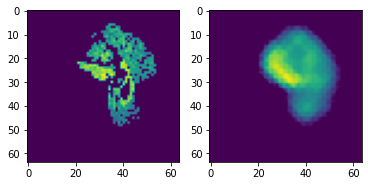

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


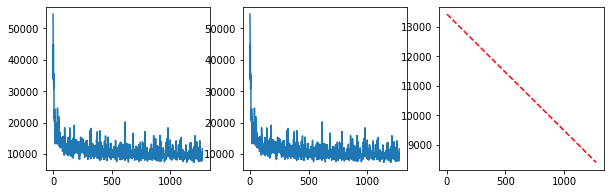

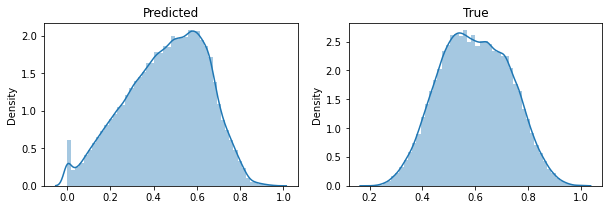

epoch 6/501 | batch 0/212.0 | time 0:00:50.274035 | loss 11336.42773
epoch 6/501 | batch 50/212.0 | time 0:00:51.865719 | loss 9592.06934
epoch 6/501 | batch 100/212.0 | time 0:00:53.458107 | loss 9676.16602
epoch 6/501 | batch 150/212.0 | time 0:00:55.049557 | loss 9324.97852
epoch 6/501 | batch 200/212.0 | time 0:00:56.640033 | loss 8381.83105
epoch 7/501 | batch 0/212.0 | time 0:00:57.038077 | loss 8734.47754
epoch 7/501 | batch 50/212.0 | time 0:00:58.629930 | loss 8990.59375
epoch 7/501 | batch 100/212.0 | time 0:01:00.221368 | loss 9448.57227
epoch 7/501 | batch 150/212.0 | time 0:01:01.814083 | loss 7515.05664
epoch 7/501 | batch 200/212.0 | time 0:01:03.404342 | loss 9080.70117
epoch 8/501 | batch 0/212.0 | time 0:01:03.803210 | loss 8400.89453
epoch 8/501 | batch 50/212.0 | time 0:01:05.395988 | loss 7550.23438
epoch 8/501 | batch 100/212.0 | time 0:01:06.986783 | loss 10036.96289
epoch 8/501 | batch 150/212.0 | time 0:01:08.578952 | loss 8779.38477
epoch 8/501 | batch 200/212

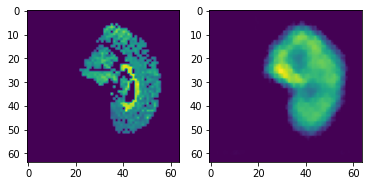

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


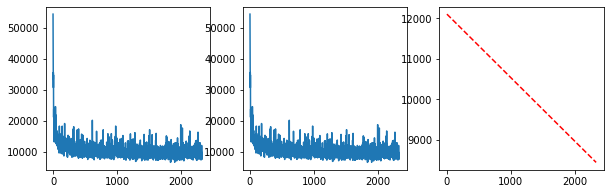

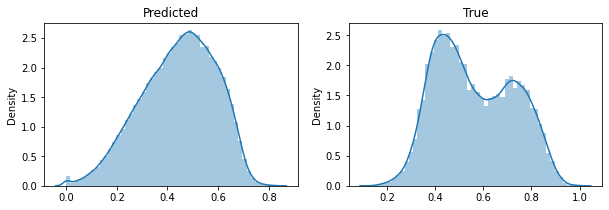

epoch 11/501 | batch 0/212.0 | time 0:01:28.277661 | loss 9629.90723
epoch 11/501 | batch 50/212.0 | time 0:01:29.943566 | loss 7131.60254
epoch 11/501 | batch 100/212.0 | time 0:01:31.545253 | loss 7741.81689
epoch 11/501 | batch 150/212.0 | time 0:01:33.144143 | loss 7990.66699
epoch 11/501 | batch 200/212.0 | time 0:01:34.743484 | loss 8704.44141
epoch 12/501 | batch 0/212.0 | time 0:01:35.143640 | loss 8593.42773
epoch 12/501 | batch 50/212.0 | time 0:01:36.744335 | loss 8711.08887
epoch 12/501 | batch 100/212.0 | time 0:01:38.345319 | loss 8941.02246
epoch 12/501 | batch 150/212.0 | time 0:01:39.946168 | loss 11439.99023
epoch 12/501 | batch 200/212.0 | time 0:01:41.555432 | loss 10689.11426
epoch 13/501 | batch 0/212.0 | time 0:01:41.955809 | loss 7988.69238
epoch 13/501 | batch 50/212.0 | time 0:01:43.556763 | loss 10160.09766
epoch 13/501 | batch 100/212.0 | time 0:01:45.159190 | loss 10669.09277
epoch 13/501 | batch 150/212.0 | time 0:01:46.759373 | loss 10554.70703
epoch 13/5

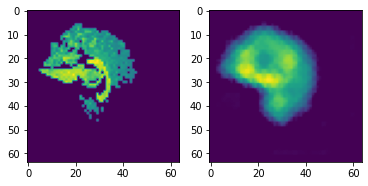

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


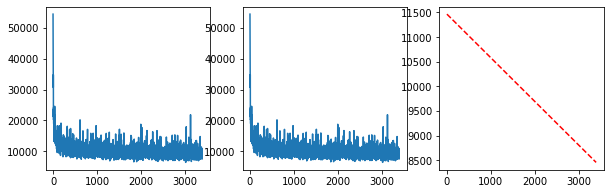

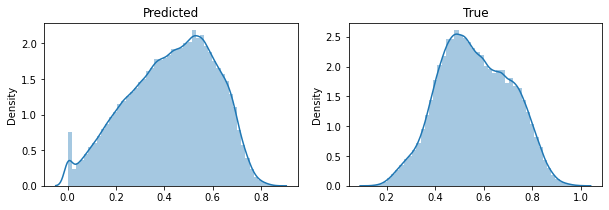

epoch 16/501 | batch 0/212.0 | time 0:02:06.606824 | loss 10057.67969
epoch 16/501 | batch 50/212.0 | time 0:02:08.206877 | loss 8459.40332
epoch 16/501 | batch 100/212.0 | time 0:02:09.805742 | loss 7839.12988
epoch 16/501 | batch 150/212.0 | time 0:02:11.406121 | loss 9132.2207
epoch 16/501 | batch 200/212.0 | time 0:02:13.004958 | loss 13439.33984
epoch 17/501 | batch 0/212.0 | time 0:02:13.405157 | loss 7429.31006
epoch 17/501 | batch 50/212.0 | time 0:02:15.004019 | loss 9431.37695
epoch 17/501 | batch 100/212.0 | time 0:02:16.603494 | loss 10377.93164
epoch 17/501 | batch 150/212.0 | time 0:02:18.201800 | loss 12362.33789
epoch 17/501 | batch 200/212.0 | time 0:02:19.803057 | loss 11198.73438
epoch 18/501 | batch 0/212.0 | time 0:02:20.203263 | loss 9860.82812
epoch 18/501 | batch 50/212.0 | time 0:02:21.803220 | loss 10122.90137
epoch 18/501 | batch 100/212.0 | time 0:02:23.403512 | loss 7974.35156
epoch 18/501 | batch 150/212.0 | time 0:02:25.003074 | loss 8383.20508
epoch 18/5

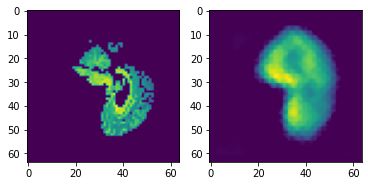

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


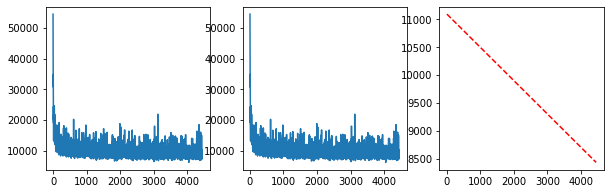

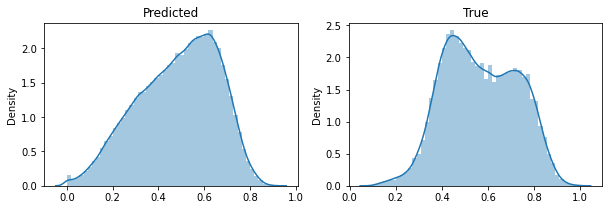

epoch 21/501 | batch 0/212.0 | time 0:02:44.679062 | loss 9715.23926
epoch 21/501 | batch 50/212.0 | time 0:02:46.318579 | loss 8756.36523
epoch 21/501 | batch 100/212.0 | time 0:02:47.919297 | loss 10074.44727
epoch 21/501 | batch 150/212.0 | time 0:02:49.518742 | loss 9179.37109
epoch 21/501 | batch 200/212.0 | time 0:02:51.117354 | loss 7611.15723
epoch 22/501 | batch 0/212.0 | time 0:02:51.517824 | loss 10812.46094
epoch 22/501 | batch 50/212.0 | time 0:02:53.117363 | loss 10171.1543
epoch 22/501 | batch 100/212.0 | time 0:02:54.718197 | loss 11379.97656
epoch 22/501 | batch 150/212.0 | time 0:02:56.317655 | loss 9411.6875
epoch 22/501 | batch 200/212.0 | time 0:02:57.918023 | loss 9737.93848
epoch 23/501 | batch 0/212.0 | time 0:02:58.318568 | loss 8395.46875
epoch 23/501 | batch 50/212.0 | time 0:02:59.919372 | loss 9100.16211
epoch 23/501 | batch 100/212.0 | time 0:03:01.518936 | loss 8426.57422
epoch 23/501 | batch 150/212.0 | time 0:03:03.119840 | loss 8881.84668
epoch 23/501 

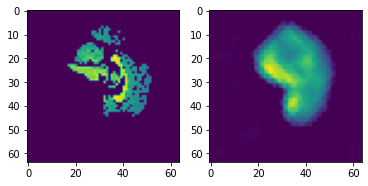

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


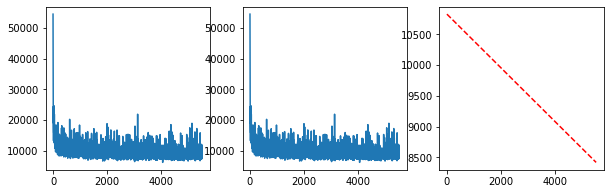

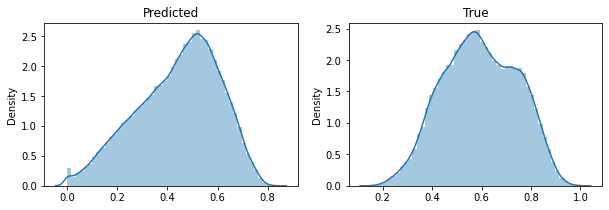

epoch 26/501 | batch 0/212.0 | time 0:03:22.874540 | loss 8945.92773
epoch 26/501 | batch 50/212.0 | time 0:03:24.474441 | loss 7897.41016
epoch 26/501 | batch 100/212.0 | time 0:03:26.072895 | loss 8119.24268
epoch 26/501 | batch 150/212.0 | time 0:03:27.672625 | loss 7193.17334
epoch 26/501 | batch 200/212.0 | time 0:03:29.271486 | loss 8537.54004
epoch 27/501 | batch 0/212.0 | time 0:03:29.671322 | loss 8447.80078
epoch 27/501 | batch 50/212.0 | time 0:03:31.270423 | loss 9303.5
epoch 27/501 | batch 100/212.0 | time 0:03:32.869538 | loss 9778.81445
epoch 27/501 | batch 150/212.0 | time 0:03:34.467973 | loss 13126.86816
epoch 27/501 | batch 200/212.0 | time 0:03:36.067531 | loss 8522.24902
epoch 28/501 | batch 0/212.0 | time 0:03:36.467854 | loss 8601.1582
epoch 28/501 | batch 50/212.0 | time 0:03:38.066594 | loss 9549.13281
epoch 28/501 | batch 100/212.0 | time 0:03:39.665021 | loss 7035.66309
epoch 28/501 | batch 150/212.0 | time 0:03:41.264530 | loss 9019.98242
epoch 28/501 | batc

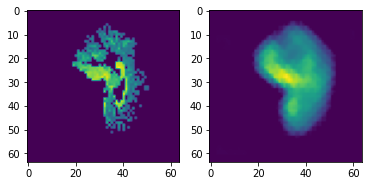

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


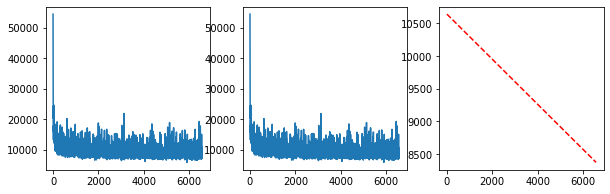

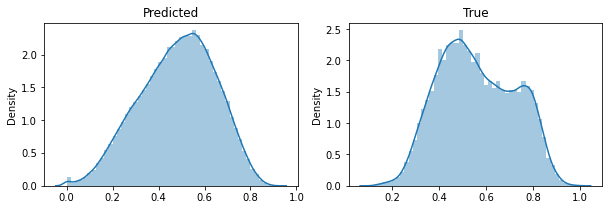

epoch 31/501 | batch 0/212.0 | time 0:04:01.283870 | loss 8019.94189
epoch 31/501 | batch 50/212.0 | time 0:04:02.899317 | loss 7719.20703
epoch 31/501 | batch 100/212.0 | time 0:04:04.499993 | loss 8967.93457
epoch 31/501 | batch 150/212.0 | time 0:04:06.099099 | loss 7613.44824
epoch 31/501 | batch 200/212.0 | time 0:04:07.697693 | loss 7065.45215
epoch 32/501 | batch 0/212.0 | time 0:04:08.098682 | loss 7895.31152
epoch 32/501 | batch 50/212.0 | time 0:04:09.697364 | loss 7219.73193
epoch 32/501 | batch 100/212.0 | time 0:04:11.296155 | loss 9114.0625
epoch 32/501 | batch 150/212.0 | time 0:04:12.895027 | loss 9279.69238
epoch 32/501 | batch 200/212.0 | time 0:04:14.493094 | loss 8528.64746
epoch 33/501 | batch 0/212.0 | time 0:04:14.893651 | loss 8947.89551
epoch 33/501 | batch 50/212.0 | time 0:04:16.491617 | loss 8572.30469
epoch 33/501 | batch 100/212.0 | time 0:04:18.091460 | loss 6800.74023
epoch 33/501 | batch 150/212.0 | time 0:04:19.689260 | loss 8583.22461
epoch 33/501 | b

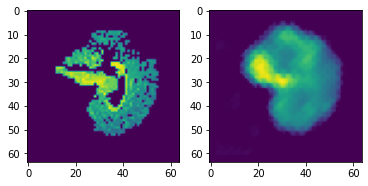

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


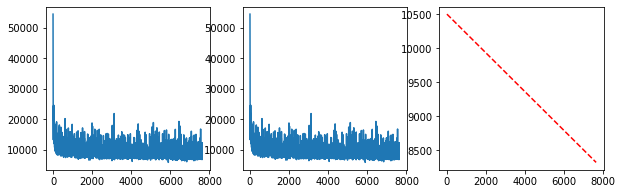

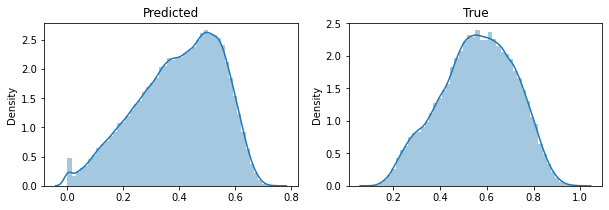

epoch 36/501 | batch 0/212.0 | time 0:04:39.325888 | loss 8713.61133
epoch 36/501 | batch 50/212.0 | time 0:04:40.929843 | loss 9384.25293
epoch 36/501 | batch 100/212.0 | time 0:04:42.533629 | loss 8054.97217
epoch 36/501 | batch 150/212.0 | time 0:04:44.138491 | loss 7467.98877
epoch 36/501 | batch 200/212.0 | time 0:04:45.744329 | loss 9026.64453
epoch 37/501 | batch 0/212.0 | time 0:04:46.145626 | loss 7757.66309
epoch 37/501 | batch 50/212.0 | time 0:04:47.750672 | loss 8778.57031
epoch 37/501 | batch 100/212.0 | time 0:04:49.355689 | loss 7857.08105
epoch 37/501 | batch 150/212.0 | time 0:04:50.959774 | loss 9393.6582
epoch 37/501 | batch 200/212.0 | time 0:04:52.564539 | loss 7390.53076
epoch 38/501 | batch 0/212.0 | time 0:04:52.965767 | loss 8703.27539
epoch 38/501 | batch 50/212.0 | time 0:04:54.571806 | loss 8333.21191
epoch 38/501 | batch 100/212.0 | time 0:04:56.176803 | loss 8681.57324
epoch 38/501 | batch 150/212.0 | time 0:04:57.780952 | loss 9725.32324
epoch 38/501 | b

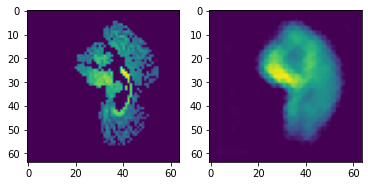

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


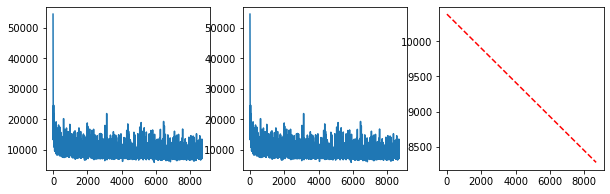

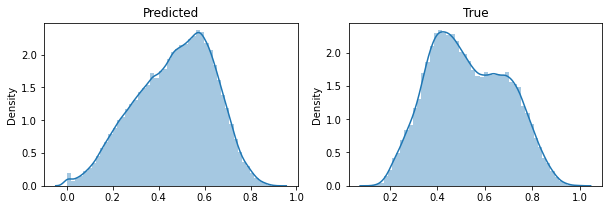

epoch 41/501 | batch 0/212.0 | time 0:05:17.374622 | loss 7642.9751
epoch 41/501 | batch 50/212.0 | time 0:05:19.011800 | loss 14575.08008
epoch 41/501 | batch 100/212.0 | time 0:05:20.610697 | loss 8389.9707
epoch 41/501 | batch 150/212.0 | time 0:05:22.210625 | loss 8751.38477
epoch 41/501 | batch 200/212.0 | time 0:05:23.809293 | loss 7389.54297
epoch 42/501 | batch 0/212.0 | time 0:05:24.209196 | loss 9472.40039
epoch 42/501 | batch 50/212.0 | time 0:05:25.808127 | loss 9595.65137
epoch 42/501 | batch 100/212.0 | time 0:05:27.407927 | loss 9400.56641
epoch 42/501 | batch 150/212.0 | time 0:05:29.008107 | loss 10064.40039
epoch 42/501 | batch 200/212.0 | time 0:05:30.606239 | loss 7817.79492
epoch 43/501 | batch 0/212.0 | time 0:05:31.007212 | loss 10408.07324
epoch 43/501 | batch 50/212.0 | time 0:05:32.606211 | loss 8230.40137
epoch 43/501 | batch 100/212.0 | time 0:05:34.204848 | loss 8311.64551
epoch 43/501 | batch 150/212.0 | time 0:05:35.803394 | loss 7843.92871
epoch 43/501 |

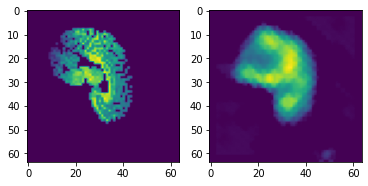

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


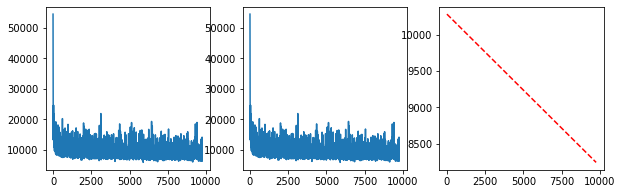

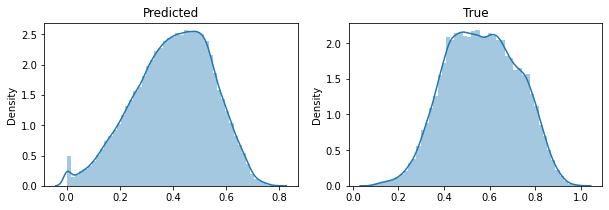

epoch 46/501 | batch 0/212.0 | time 0:05:55.387164 | loss 8832.08594
epoch 46/501 | batch 50/212.0 | time 0:05:56.992751 | loss 7523.36621


KeyboardInterrupt: ignored

In [ ]:
t0 = datetime.now();
for epoch in range(int(num_epochs)):
    permutation = np.random.permutation(ndata)
    D = D[permutation,:,:,:,:]
    for batch_idx in range(int(n_batches)):
        optimizer.zero_grad()
        data_batch = D[batches[batch_idx,:],:,:,:,:]
        outputs = model.forward(data_batch)
        #train_loss = criterion(outputs,data_batch)
        train_loss = myLoss(outputs,data_batch)
        train_loss.backward()
        optimizer.step()
        track.append(train_loss.item())
        if batch_idx%50==0:
          print(f"epoch {epoch}/{num_epochs} | batch {batch_idx}/{n_batches} | time {str(datetime.now()-t0)} | loss {round(train_loss.item(),5)}")


    track = track[-min(len(track),10000)::]

    if epoch%100==0:
      ofn = os.path.join(ofdir,f'{session_name}' + f'e{epoch}_'+str(now()))
      print('saved')
      print(ofn)
      torch.save(model.state_dict(),ofn)
     
    if epoch%5==0:
      print(outputs.view(-1))
      plt.figure()
      plt.subplot(1,2,1)
      plt.imshow(data_batch.cpu().detach().numpy()[0,0,32,:,:])
      plt.subplot(1,2,2)
      plt.imshow(outputs.cpu().detach().numpy()[0,0,32,:,:])
      plt.show()

      plt.figure(figsize=(10,3))
      plt.subplot(1,3,1)
      plt.plot(track)
      plt.subplot(1,3,2)
      t = track
      plt.plot(t)

      xs = np.arange(len(t))+1
      z = np.polyfit(xs, t, 1)
      p = np.poly1d(z)
      plt.subplot(1,3,3)
      plt.plot(xs,p(xs),"r--")


      b = outputs.cpu().detach()
      a = data_batch.cpu().detach()
      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      sns.distplot(np.array(b[a>0.001]).flatten())
      plt.title('Predicted')
      plt.subplot(1,2,2)
      sns.distplot(np.array(a[a>0.001]).flatten())
      plt.title('True')
      plt.show()

In [ ]:
print('all done')